# 1. Objetivo

La idea del proycto es realizar una clasificación de imágenes en tres clases -> Frutas, Vegetales y Paquetes.

#### data set reference
```
  title={A Hierarchical Grocery Store Image Dataset with Visual and Semantic Labels},
  author={Klasson, Marcus and Zhang, Cheng and Kjellstr{\"o}m, Hedvig},
  booktitle={IEEE Winter Conference on Applications of Computer Vision (WACV)},
  year={2019}
```

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

#### Algunas funciones útiles

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  


# 2. Descarga y Armado del dataset

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6553, done.
remote: Total 6553 (delta 0), reused 0 (delta 0), pack-reused 6553
Receiving objects: 100% (6553/6553), 116.24 MiB | 40.42 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [ ]:
## fijamos los paths
train_path = './GroceryStoreDataset/dataset/train' 
validation_path = './GroceryStoreDataset/dataset/val'
test_path = './GroceryStoreDataset/dataset/test'

In [ ]:
!ls GroceryStoreDataset/dataset/val

Fruit  Packages  Vegetables


## 2.2 Preprocesamiento inicial de los datos¿
Creamos algunos preprocesamientos sin ningun variación ni aumento de los datos. Este es el comienzo :)

In [ ]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 8)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224,224), classes = ['Fruit', 'Packages', 'Vegetables'], batch_size = 32)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Found 2485 images belonging to 3 classes.


In [ ]:
#take a look at output of the generators

for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break
    

data batch shape: (32, 224, 224, 3)
labels batch shape: (32, 3)


# 3. Crear un Modelo base Convolusional

In [ ]:
from keras import layers
from keras import models


model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(96, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 96)                37850208  
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 291       
Total params: 37,851,395
Trainable params: 37,851,395
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_filenames = train_batches.filenames
steps_train = len(train_filenames)/train_batches.batch_size

validation_filenames = validation_batches.filenames
steps_valid = len(validation_filenames)/validation_batches.batch_size

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator1 = model.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=5,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/5
83/82 [==============================] - 9s 114ms/step - loss: 358.6493 - acc: 0.5114 - val_loss: 285.1473 - val_acc: 0.5203
Epoch 2/5
83/82 [==============================] - 9s 114ms/step - loss: 125.9946 - acc: 0.6326 - val_loss: 63.4967 - val_acc: 0.5642
Epoch 3/5
83/82 [==============================] - 9s 113ms/step - loss: 81.5826 - acc: 0.6754 - val_loss: 64.9754 - val_acc: 0.6216
Epoch 4/5
83/82 [==============================] - 9s 114ms/step - loss: 45.5042 - acc: 0.7288 - val_loss: 60.6064 - val_acc: 0.5946
Epoch 5/5
83/82 [==============================] - 9s 113ms/step - loss: 21.2221 - acc: 0.7780 - val_loss: 36.1126 - val_acc: 0.5541


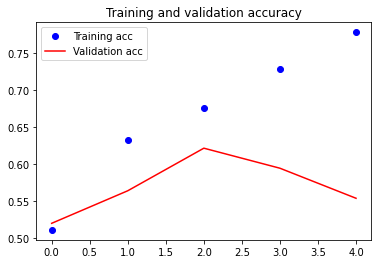

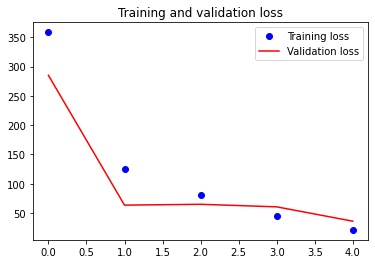

In [ ]:

import matplotlib.pyplot as plt

acc = fit_generator1.history['acc']
val_acc = fit_generator1.history['val_acc']
loss = fit_generator1.history['loss']
val_loss = fit_generator1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Modelo Complejo


### 3.1.1 Experimentamos con el modelo :
 
 Capa convolusional con 32 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 64 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 128 neuronas
 
 Capa Pooling
 
 Capa Convolusional con 128 neuronas
 
 Capa Pooling
 
 Capa de Aplanamiento
 
 Capa Densa con 512 neuronas
 
 Capa de clasificación con la categorías.
 
 ** y obviamente probar con más épocas ** 
 
 Se recomienda entrenar con gpu (o en colab), aunque puede andar sin, aunque bastante lento

In [ ]:
#elejimos un modelo secuencial
model_2 = models.Sequential()
# agregamos capa convolucional de 32 neuronas y capa de pooling
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_2.add(layers.MaxPooling2D((2, 2)))

# agregamos capa convolucional de 64 neuronas y capa de pooling
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# agregamos capa convolucional de 128 neuronas y capa de pooling
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

# agregamos capa convolucional de 128 neuronas y capa de pooling
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))

#agregamos modelo de aplanamiento
model_2.add(layers.Flatten())

# agregamos capa convolucional de 512 neuronas y capa de pooling
model_2.add(layers.Dense(512, activation='relu'))
model_2.add(layers.Dense(3, activation='softmax'))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

In [ ]:

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
fit_generator2 = model_2.fit(
      train_batches,
      steps_per_epoch=steps_train,
      epochs=100,
      validation_data=validation_batches,
      validation_steps=steps_valid)

Epoch 1/100
83/82 [==============================] - 12s 145ms/step - loss: 5.8877 - acc: 0.6087 - val_loss: 0.8971 - val_acc: 0.6520
Epoch 2/100
83/82 [==============================] - 11s 138ms/step - loss: 0.5651 - acc: 0.7769 - val_loss: 0.8420 - val_acc: 0.6453
Epoch 3/100
83/82 [==============================] - 12s 139ms/step - loss: 0.2949 - acc: 0.8917 - val_loss: 1.3779 - val_acc: 0.5878
Epoch 4/100
83/82 [==============================] - 11s 138ms/step - loss: 0.2025 - acc: 0.9318 - val_loss: 1.0230 - val_acc: 0.6926
Epoch 5/100
83/82 [==============================] - 11s 138ms/step - loss: 0.1605 - acc: 0.9655 - val_loss: 1.3188 - val_acc: 0.6419
Epoch 6/100
83/82 [==============================] - 11s 138ms/step - loss: 0.1574 - acc: 0.9670 - val_loss: 1.4353 - val_acc: 0.6588
Epoch 7/100
83/82 [==============================] - 11s 138ms/step - loss: 0.1146 - acc: 0.9742 - val_loss: 2.3143 - val_acc: 0.6351
Epoch 8/100
83/82 [==============================] - 11s 138ms

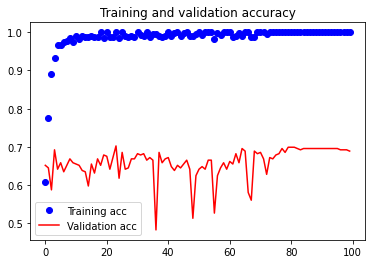

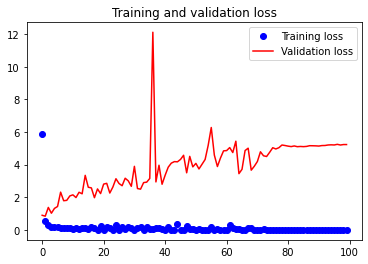

In [ ]:

acc2 = fit_generator2.history['acc']
val_acc2 = fit_generator2.history['val_acc']
loss2 = fit_generator2.history['loss']
val_loss2 = fit_generator2.history['val_loss']

epochs2 = range(len(acc2))

plt.plot(epochs2, acc2, 'bo', label='Training acc')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# aumento de datos

### 3.2 Hacer Aumento de datos

Al modelo anterior le hacemos data augmentation 
https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# creamos un imagen data generator configurando los hiperparametros de rescalado, zoom, flip y cortes aleratorios

train_datagen = ImageDataGenerator(
        rescale= 1./255,
        shear_range= 0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])
#entrenamos el modelo
fit_generator_2 = model_2.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)




Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Epoch 1/30
 9/52 [====>.........................] - ETA: 20s - loss: 1.0777 - acc: 0.4222

KeyboardInterrupt: ignored

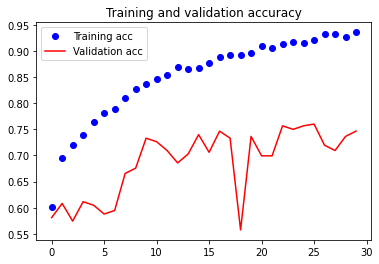

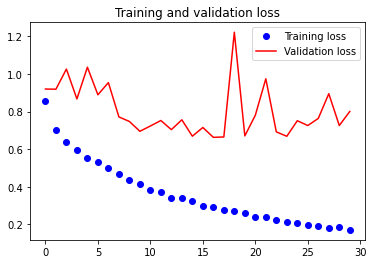

In [ ]:

import matplotlib.pyplot as plt

acc = fit_generator_2.history['acc']
val_acc = fit_generator_2.history['val_acc']
loss = fit_generator_2.history['loss']
val_loss = fit_generator_2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# mas aumentos de imagenes

### 3.3 Más aumentos de imágenes 

Agregamos otros aumentos:

* rango de rotación (rotation_range) rota las imagenes.
* desplazar las imagenes aleatoriamente con (width_shift) en ancho
* desplazar las imagenes aleatoriamente con (height_shift) en ancho
* poner fill_mode en nearest para completar la imagen.


In [ ]:
#esta vez al imagen data generator se le va a agregar desplazamiento en ancho y alto , rotazion y completar la imagen
train_datagen = ImageDataGenerator(rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode= 'nearest',
        rescale= 1./255,
        shear_range= 0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.2,1.2])

test_datagen = ImageDataGenerator(testPath,
	class_mode="categorical",
	target_size=(224, 224), rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model_2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_3 = model_2.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Epoch 1/30
53/52 [==============================] - 41s 772ms/step - loss: 0.4293 - acc: 0.8311 - val_loss: 0.7751 - val_acc: 0.7365
Epoch 2/30
53/52 [==============================] - 41s 769ms/step - loss: 0.4009 - acc: 0.8443 - val_loss: 0.9575 - val_acc: 0.7095
Epoch 3/30
53/52 [==============================] - 41s 774ms/step - loss: 0.3693 - acc: 0.8583 - val_loss: 0.7374 - val_acc: 0.7466
Epoch 4/30
53/52 [==============================] - 41s 769ms/step - loss: 0.3652 - acc: 0.8625 - val_loss: 0.7406 - val_acc: 0.7804
Epoch 5/30
53/52 [==============================] - 40s 760ms/step - loss: 0.3584 - acc: 0.8595 - val_loss: 0.7095 - val_acc: 0.7601
Epoch 6/30
53/52 [==============================] - 40s 758ms/step - loss: 0.3393 - acc: 0.8701 - val_loss: 0.8292 - val_acc: 0.7466
Epoch 7/30
53/52 [==============================] - 40s 760ms/step - loss: 0.3412 - acc: 0.8686 - val_loss: 0.7586 - va

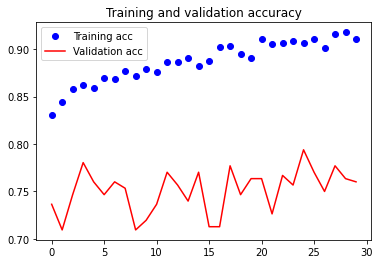

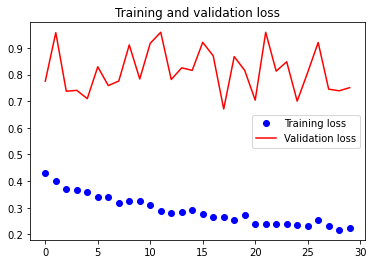

In [ ]:
acc = fit_generator_3.history['acc']
val_acc = fit_generator_3.history['val_acc']
loss = fit_generator_3.history['loss']
val_loss = fit_generator_3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# regularizacion

### 3.3 Regularización: Añadir capa o capas de dropout para regularizar.


In [ ]:
model_3 = models.Sequential()

model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))


model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))


model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))


model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))


model_3.add(layers.Flatten())
model_3.add(layers.Dense(512, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(layers.Dense(3, activation='softmax'))
model_3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)      

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode= 'nearest',
        rescale= 1./255,
        shear_range= 0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.2,1.2])

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=50,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

train_filenames = train_generator.filenames
steps_train = len(train_filenames)/train_generator.batch_size

validation_filenames = validation_generator.filenames
steps_valid = len(validation_filenames)/validation_generator.batch_size

model_3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

fit_generator_4 = model_3.fit(
        train_generator,
        steps_per_epoch=steps_train,
        epochs=40,
        validation_data=validation_generator,
        validation_steps=steps_valid)

Found 2640 images belonging to 3 classes.
Found 296 images belonging to 3 classes.
Epoch 1/40
53/52 [==============================] - 40s 757ms/step - loss: 0.5579 - acc: 0.7761 - val_loss: 0.8977 - val_acc: 0.6182
Epoch 2/40
53/52 [==============================] - 39s 745ms/step - loss: 0.5236 - acc: 0.7970 - val_loss: 0.9376 - val_acc: 0.6993
Epoch 3/40
53/52 [==============================] - 39s 745ms/step - loss: 0.5198 - acc: 0.7860 - val_loss: 0.8900 - val_acc: 0.6926
Epoch 4/40
53/52 [==============================] - 39s 734ms/step - loss: 0.4897 - acc: 0.8061 - val_loss: 0.7727 - val_acc: 0.7196
Epoch 5/40
53/52 [==============================] - 39s 741ms/step - loss: 0.4924 - acc: 0.8034 - val_loss: 0.8431 - val_acc: 0.7230
Epoch 6/40
53/52 [==============================] - 40s 746ms/step - loss: 0.4498 - acc: 0.8250 - val_loss: 0.7141 - val_acc: 0.7399
Epoch 7/40
53/52 [==============================] - 40s 749ms/step - loss: 0.4503 - acc: 0.8303 - val_loss: 0.8955 - va

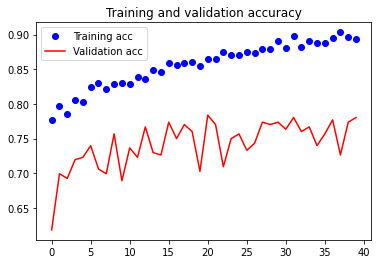

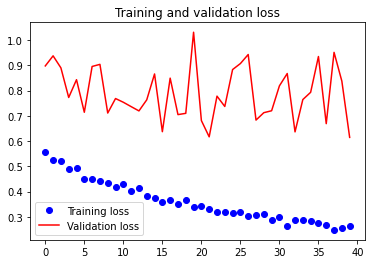

In [ ]:
acc = fit_generator_4.history['acc']
val_acc = fit_generator_4.history['val_acc']
loss = fit_generator_4.history['loss']
val_loss = fit_generator_4.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# el proximo codigo da como resultado las imagenes de abajo
#model_3 = models.Sequential()

#model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
#model_3.add(layers.MaxPooling2D((2, 2)))
#model_3.add(Dropout(0.5))

#model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model_3.add(layers.MaxPooling2D((2, 2)))
#model_3.add(Dropout(0.5))

#model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model_3.add(layers.MaxPooling2D((2, 2)))
#model_3.add(Dropout(0.5))

#model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
#model_3.add(layers.MaxPooling2D((2, 2)))
#model_3.add(Dropout(0.5))

#model_3.add(layers.Flatten())
#model_3.add(layers.Dense(512, activation='relu'))
#model_3.add(Dropout(0.5))
#model_3.add(layers.Dense(3, activation='softmax'))
#model_3.summary()

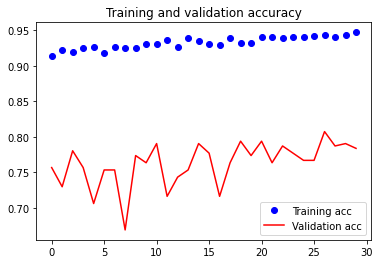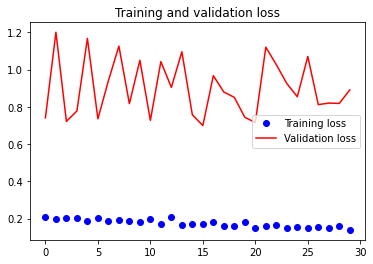

# 4. Utilizar una Red Preentrenada y hacer Fine-Tuning!

Utilizamos la red VGG16, recortando las últimas capas de la red para hacer fine tuning. 

https://www.pyimagesearch.com/2019/06/03/fine-tuning-with-keras-and-deep-learning/

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import keras
from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K

from tensorflow.keras.applications import VGG16

In [ ]:
#### Recuerden que aquí, cuando ya estén medio estables con los resultados, pueden empezar a jugar con los optimizadores y también realizar el aumento de imágenes para el modelo con vgg o resnet :)
#### SUERTE Y CUALQUIER COSA  ME PREGUNTAN!

In [ ]:
# cargamos las red neuronal "VGG16"

from tensorflow.keras.layers import Input
#creamos el modelo base
base = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


#contruimos la cabeza del modelo que luego se unira en la parte final del modelo base
head = base.output
head = Flatten(name="flatten")(head)
head = Dense(512, activation="relu")(head)
head = Dropout(0.5)(headModel)
head = Dense(3, activation="softmax")(head)


#unimos el modelo base y el modelo head
model = Model(inputs=base.input, outputs=head)

#congelamos todas las capas que pertenecen la modelo base

for layer in base.layers:
	layer.trainable = False

58892288/58889256 [==============================] - 2s 0us/step


In [ ]:

from tensorflow.keras.optimizers import SGD

#compilamos el modelo
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

#entrenamos la cabeza de la neurona ya que las demas estan congeladas
print("[INFO] training head...")
modelo = model.fit(
	train_generator,
	steps_per_epoch=steps_train,
	validation_data=validation_generator,
	validation_steps=steps_valid,
	epochs=30)




[INFO] compiling model...
[INFO] training head...
Epoch 1/30
53/52 [==============================] - 33s 627ms/step - loss: 0.7223 - accuracy: 0.6928 - val_loss: 0.5296 - val_accuracy: 0.7770
Epoch 2/30
53/52 [==============================] - 33s 615ms/step - loss: 0.5061 - accuracy: 0.7841 - val_loss: 0.4403 - val_accuracy: 0.8243
Epoch 3/30
53/52 [==============================] - 33s 616ms/step - loss: 0.4430 - accuracy: 0.8125 - val_loss: 0.4143 - val_accuracy: 0.8311
Epoch 4/30
53/52 [==============================] - 33s 613ms/step - loss: 0.4072 - accuracy: 0.8208 - val_loss: 0.3967 - val_accuracy: 0.8378
Epoch 5/30
53/52 [==============================] - 33s 616ms/step - loss: 0.3937 - accuracy: 0.8239 - val_loss: 0.3889 - val_accuracy: 0.8277
Epoch 6/30
53/52 [==============================] - 33s 617ms/step - loss: 0.3680 - accuracy: 0.8455 - val_loss: 0.3701 - val_accuracy: 0.8412
Epoch 7/30
53/52 [==============================] - 33s 614ms/step - loss: 0.3531 - accuracy

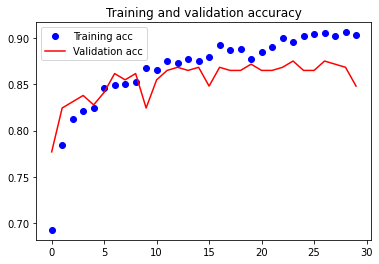

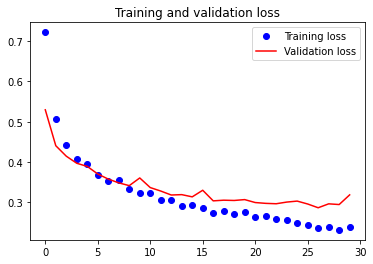

In [ ]:
acc = modelo.history['accuracy']
val_acc = modelo.history['val_accuracy']
loss = modelo.history['loss']
val_loss = modelo.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc', color = 'r')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color = 'r')
plt.title('Training and validation loss')
plt.legend()

plt.show()